In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from copy import deepcopy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
nltk.download('stopwords', quiet=True)

True

In [364]:
df = pd.read_csv("Twitter.csv")
df.head()

,clean_text,category,category_sentiment
0,when modi promised “minimum government maximum...,-1,negative
1,talk all the nonsense and continue all the dra...,0,neutral
2,what did just say vote for modi welcome bjp t...,1,positive
3,asking his supporters prefix chowkidar their n...,1,positive
4,answer who among these the most powerful world...,1,positive


In [365]:
df = df.dropna()
df["category"] = df["category"].astype(int)
df = df.reset_index(drop=True)
df["category"].value_counts()

 1    72254
 0    62713
-1    43019
Name: category, dtype: int64

In [366]:
df = df[df["category"] != 0]
df["category"].value_counts()

 1    72254
-1    43019
Name: category, dtype: int64

In [367]:
df = df.sample(frac=1).reset_index(drop=True) #shuffling of tweets
data = df[df["category"] == -1][:40000]
data = data.append(df[df["category"] == 1][:40000])
data = data.reset_index(drop=True)
display(data["category"].value_counts())
data

C:\Users\JDEGUZMAN\AppData\Local\Temp\ipykernel_1300\1585417336.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df[df["category"] == 1][:40000])


-1    40000
 1    40000
Name: category, dtype: int64

,clean_text,category,category_sentiment
0,few people india and out india find themself b...,-1,negative
1,omar abdullah lashes out modi for ‘destroying’...,-1,negative
2,'bumped her leg into the bed side and now carr...,-1,negative
3,name one institution set modi the institution ...,-1,negative
4,modi waste well dangerous indias economy secur...,-1,negative
...,...,...,...
79995,fear cycle over and greed cycle back funny see...,1,positive
79996,attorney nirav modi has been the since january...,1,positive
79997,any modi supporter for development finds words...,1,positive
79998,and the very same reason fan modi his strategi...,1,positive


In [368]:
# Also lets encode 'sentiment' column. 1 for positive and 0 for negative sentiment
data["category"] = data["category"].map({-1:0, 1:1}) 

In [369]:
#create a dictionary to store the words and its corresponding values
#convert words to 50 numbers using glove.6B.50d

words = dict()

def add_to_dict(d, filename):
    with open(filename, "r", encoding="utf8") as f:
        for line in f.readlines():
            line = line.split(' ')
            
            try:
                d[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue

In [370]:
add_to_dict(words, "glove.6B.50d.txt")

In [371]:
#sample tokenize a tweet
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [372]:
#function that will replace group words into its simplest form
lemmatizer = WordNetLemmatizer()

def message_to_token_list(s):
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]
    
    return useful_tokens

In [373]:
#function that will replace each words to its corresponding word embedding
def message_to_word_vectors(message, word_dict=words):
    processed_list_of_tokens = message_to_token_list(message)
    
    vectors = []
    
    for token in processed_list_of_tokens:
        if token not in word_dict:
            continue
        
        token_vector = word_dict[token]
        vectors.append(token_vector)
        
    return np.array(vectors, dtype=float)

In [374]:
#convert dataframe into train and test sets

train_df = data.sample(frac=1, random_state=1)
train_df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(train_df) * 0.7)
split_index_2 = int(len(train_df) * 0.85)

train_df, val_df, test_df = train_df[:split_index_1], train_df[split_index_1:split_index_2], train_df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(56000, 12000, 12000)

In [375]:
def df_to_X_y(dataframe):
    y = dataframe["category"].to_numpy().astype(int)
    
    all_word_vector_sequences = []
    
    for message in dataframe["clean_text"]:
        message_as_vector_seq = message_to_word_vectors(message)
        
        if message_as_vector_seq.shape[0] == 0: #if there are no usable tokens in the tweet
            message_as_vector_seq = np.zeros(shape=(1, 50))
            
        all_word_vector_sequences.append(message_as_vector_seq)
    
    return all_word_vector_sequences, y

In [376]:
X_train, y_train = df_to_X_y(train_df)

print(len(X_train), len(X_train[0]))

56000 27


(array([2363., 7380., 9042., 8508., 7867., 7846., 7517., 4577.,  877.,
          23.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

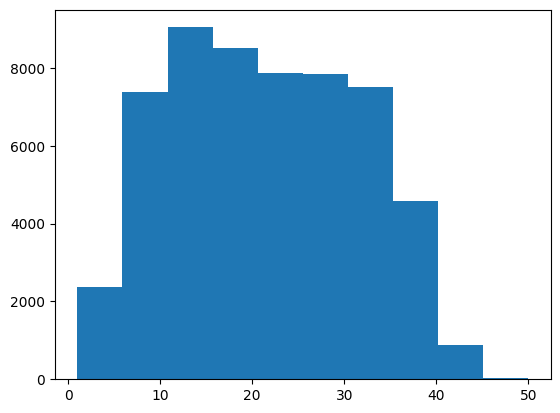

In [377]:
#data analysis for sequence lengths (number of terms in the sequence)

sequence_lengths = []

for i in range(len(X_train)):
    sequence_lengths.append(len(X_train[i]))
    
plt.hist(sequence_lengths)

In [378]:
#max value will give us the maximum number of useful tokens in a single message

pd.Series(sequence_lengths).describe()

count    56000.000000
mean        21.399661
std         10.178850
min          1.000000
25%         13.000000
50%         21.000000
75%         30.000000
max         50.000000
dtype: float64

In [379]:
#zero padding

def pad_X(X, desired_sequence_length=50):
    X_copy = deepcopy(X)
    
    for i,x in enumerate(X):
        x_seq_len = x.shape[0]
        sequence_length_difference = desired_sequence_length - x_seq_len
        
        pad = np.zeros(shape=(sequence_length_difference, 50))
        
        X_copy[i] = np.concatenate([x, pad])
        
    return np.array(X_copy).astype(float)

In [380]:
#show how many tweets we have and the dimension of each tweet
#the dimension of each tweet is in the form (sequences of # of vectors, # of dimensions = 50)

X_train = pad_X(X_train)
X_train.shape

(56000, 50, 50)

In [381]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

In [382]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

In [383]:
model = Sequential([])

model.add(layers.Input(shape=(50, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

In [384]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 50, 64)            29440     
                                                                 
 dropout_25 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 50, 64)            33024     
                                                                 
 dropout_26 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_27 (LSTM)              (None, 50, 64)            33024     
                                                                 
 dropout_27 (Dropout)        (None, 50, 64)            0         
                                                                 
 flatten_9 (Flatten)         (None, 3200)             

In [385]:
cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy', AUC(name='auc')])

In [386]:
frequencies = pd.value_counts(train_df["category"])

frequencies

1    28050
0    27950
Name: category, dtype: int64

In [387]:
# 0 = negative
# 1 = positive
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}

weights

{0: 2.0035778175313057, 1: 1.9964349376114081}

In [388]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
1750/1750 [==============================] - ETA: 0s - loss: 1.2031 - accuracy: 0.6628 - auc: 0.7292

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 287s 162ms/step - loss: 1.2031 - accuracy: 0.6628 - auc: 0.7292 - val_loss: 0.5621 - val_accuracy: 0.6967 - val_auc: 0.7806
Epoch 2/20
1750/1750 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.7022 - auc: 0.7822

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 492s 281ms/step - loss: 1.1011 - accuracy: 0.7022 - auc: 0.7822 - val_loss: 0.5308 - val_accuracy: 0.7210 - val_auc: 0.8027
Epoch 3/20
1750/1750 [==============================] - ETA: 0s - loss: 1.0558 - accuracy: 0.7207 - auc: 0.8042

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 407s 233ms/step - loss: 1.0558 - accuracy: 0.7207 - auc: 0.8042 - val_loss: 0.5140 - val_accuracy: 0.7300 - val_auc: 0.8211
Epoch 4/20
1750/1750 [==============================] - ETA: 0s - loss: 1.0126 - accuracy: 0.7361 - auc: 0.8236

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 460s 263ms/step - loss: 1.0126 - accuracy: 0.7361 - auc: 0.8236 - val_loss: 0.5068 - val_accuracy: 0.7360 - val_auc: 0.8338
Epoch 5/20
1750/1750 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.7505 - auc: 0.8372

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 388s 222ms/step - loss: 0.9804 - accuracy: 0.7505 - auc: 0.8372 - val_loss: 0.5030 - val_accuracy: 0.7344 - val_auc: 0.8420
Epoch 6/20
1750/1750 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.7568 - auc: 0.8457

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 620s 354ms/step - loss: 0.9577 - accuracy: 0.7568 - auc: 0.8457 - val_loss: 0.4726 - val_accuracy: 0.7614 - val_auc: 0.8507
Epoch 7/20
1750/1750 [==============================] - ETA: 0s - loss: 0.9362 - accuracy: 0.7656 - auc: 0.8540

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 930s 531ms/step - loss: 0.9362 - accuracy: 0.7656 - auc: 0.8540 - val_loss: 0.4657 - val_accuracy: 0.7702 - val_auc: 0.8562
Epoch 8/20
1750/1750 [==============================] - 1149s 656ms/step - loss: 0.9175 - accuracy: 0.7715 - auc: 0.8607 - val_loss: 0.4754 - val_accuracy: 0.7588 - val_auc: 0.8604
Epoch 9/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.7776 - auc: 0.8667

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 490s 280ms/step - loss: 0.8997 - accuracy: 0.7776 - auc: 0.8667 - val_loss: 0.4613 - val_accuracy: 0.7715 - val_auc: 0.8637
Epoch 10/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.7802 - auc: 0.8705

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 529s 302ms/step - loss: 0.8881 - accuracy: 0.7802 - auc: 0.8705 - val_loss: 0.4571 - val_accuracy: 0.7732 - val_auc: 0.8640
Epoch 11/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.7878 - auc: 0.8751

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 645s 369ms/step - loss: 0.8745 - accuracy: 0.7878 - auc: 0.8751 - val_loss: 0.4525 - val_accuracy: 0.7779 - val_auc: 0.8687
Epoch 12/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.7891 - auc: 0.8784

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 561s 321ms/step - loss: 0.8644 - accuracy: 0.7891 - auc: 0.8784 - val_loss: 0.4434 - val_accuracy: 0.7812 - val_auc: 0.8716
Epoch 13/20
1750/1750 [==============================] - 653s 373ms/step - loss: 0.8492 - accuracy: 0.7956 - auc: 0.8832 - val_loss: 0.4542 - val_accuracy: 0.7795 - val_auc: 0.8749
Epoch 14/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.7965 - auc: 0.8856

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 685s 391ms/step - loss: 0.8411 - accuracy: 0.7965 - auc: 0.8856 - val_loss: 0.4348 - val_accuracy: 0.7918 - val_auc: 0.8783
Epoch 15/20
1750/1750 [==============================] - ETA: 0s - loss: 0.8304 - accuracy: 0.8027 - auc: 0.8889

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 570s 326ms/step - loss: 0.8304 - accuracy: 0.8027 - auc: 0.8889 - val_loss: 0.4293 - val_accuracy: 0.7920 - val_auc: 0.8804
Epoch 16/20
1750/1750 [==============================] - 664s 380ms/step - loss: 0.8203 - accuracy: 0.8053 - auc: 0.8919 - val_loss: 0.4376 - val_accuracy: 0.7893 - val_auc: 0.8793
Epoch 17/20
1750/1750 [==============================] - 652s 372ms/step - loss: 0.8097 - accuracy: 0.8065 - auc: 0.8949 - val_loss: 0.4312 - val_accuracy: 0.7921 - val_auc: 0.8809
Epoch 18/20
1750/1750 [==============================] - 693s 396ms/step - loss: 0.8028 - accuracy: 0.8079 - auc: 0.8967 - val_loss: 0.4294 - val_accuracy: 0.7921 - val_auc: 0.8834
Epoch 19/20
1750/1750 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.8116 - auc: 0.8997

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 661s 378ms/step - loss: 0.7924 - accuracy: 0.8116 - auc: 0.8997 - val_loss: 0.4280 - val_accuracy: 0.7924 - val_auc: 0.8855
Epoch 20/20
1750/1750 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.8145 - auc: 0.9014

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


1750/1750 [==============================] - 1047s 598ms/step - loss: 0.7857 - accuracy: 0.8145 - auc: 0.9014 - val_loss: 0.4228 - val_accuracy: 0.7958 - val_auc: 0.8874


In [389]:
best_model = load_model('model/')

In [390]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, test_predictions))

375/375 [==============================] - 59s 153ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      6040
           1       0.82      0.75      0.78      5960

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.79      0.79      0.79     12000

